PART1


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import os
import numpy as np



DATASET_ROOT = "./pacs_data/pacs_data"
SOURCE_ONLY_MODEL_SAVE_PATH = "source_only_model.pth"



SOURCE_DOMAIN = 'art_painting'
TARGET_DOMAIN = 'cartoon'
BATCH_SIZE = 16
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
RANDOM_SEED = 42


torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

source_data_path = os.path.join(DATASET_ROOT, SOURCE_DOMAIN)
full_source_dataset = datasets.ImageFolder(source_data_path, transform=data_transforms['train'])

train_size = int(0.8 * len(full_source_dataset))
test_size = len(full_source_dataset) - train_size
source_train_dataset, source_test_dataset = random_split(full_source_dataset, [train_size, test_size])


class DatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    def __getitem__(self, index):
     
        original_img, label = self.dataset.dataset.samples[self.dataset.indices[index]]
      
        from PIL import Image
        img = Image.open(original_img).convert('RGB')
        return self.transform(img), label
    def __len__(self):
        return len(self.dataset)

source_test_dataset_transformed = DatasetWrapper(source_test_dataset, data_transforms['test'])


target_data_path = os.path.join(DATASET_ROOT, TARGET_DOMAIN)
target_dataset = datasets.ImageFolder(target_data_path, transform=data_transforms['test'])

source_train_loader = DataLoader(source_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
source_test_loader = DataLoader(source_test_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

num_classes = len(full_source_dataset.classes)
print(f"Source Domain: {SOURCE_DOMAIN}, Target Domain: {TARGET_DOMAIN}")
print(f"Number of classes: {num_classes}")
print(f"Source train samples: {len(source_train_dataset)}, Source test samples: {len(source_test_dataset)}")
print(f"Target test samples: {len(target_dataset)}")




model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(DEVICE)




criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)


if os.path.exists(SOURCE_ONLY_MODEL_SAVE_PATH):
    print(f"\nFound saved model at {SOURCE_ONLY_MODEL_SAVE_PATH}. Loading weights...")
    model.load_state_dict(torch.load(SOURCE_ONLY_MODEL_SAVE_PATH))
    print("Weights loaded successfully. Skipping training.")

else:
    print(f"\nNo saved model found. Starting training on source domain only...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for inputs, labels in source_train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(source_train_dataset)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {epoch_loss:.4f}")

    print("Finished Training.")
    
 
    print(f"Saving trained model weights to {SOURCE_ONLY_MODEL_SAVE_PATH}...")
    torch.save(model.state_dict(), SOURCE_ONLY_MODEL_SAVE_PATH)
    print("Model saved successfully.")



def evaluate(model, dataloader, domain_name):
  
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on {domain_name}: {accuracy:.2f}%")
    return accuracy

print("\n--- Evaluation Results ---")
source_accuracy = evaluate(model, source_test_loader, f"Source Test ({SOURCE_DOMAIN})")
target_accuracy = evaluate(model, target_loader, f"Target ({TARGET_DOMAIN})")
print("--------------------------")



performance_drop = source_accuracy - target_accuracy
print(f"\nPerformance drop from source to target: {performance_drop:.2f}%")

Using device: cuda
Source Domain: art_painting, Target Domain: cartoon
Number of classes: 7
Source train samples: 1638, Source test samples: 410
Target test samples: 2344

Found saved model at source_only_model.pth. Loading weights...
Weights loaded successfully. Skipping training.

--- Evaluation Results ---


C:\Users\xylic\AppData\Local\Temp\ipykernel_10724\2103727353.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(SOURCE_ONLY_MODEL_SAVE_PA

Accuracy on Source Test (art_painting): 89.51%
Accuracy on Target (cartoon): 49.62%
--------------------------

Performance drop from source to target: 39.90%


PART 2 - DANN implementation

In [ ]:
from torch.autograd import Function
torch.cuda.empty_cache()

class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        
        ctx.alpha = alpha
        
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        
        output = grad_output.neg() * ctx.alpha
        return output, None

class GradientReversalLayer(nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, x, alpha=1.0):
        return GradientReversalFunction.apply(x, alpha)



class DANN(nn.Module):
    def __init__(self, num_classes):
        super(DANN, self).__init__()
   
        self.feature_extractor = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()


        self.label_predictor = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self.domain_discriminator = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1) 
        )

        
        self.grl = GradientReversalLayer()

    def forward(self, x, alpha=1.0):
        
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)

 
        label_preds = self.label_predictor(features)
   
        reversed_features = self.grl.forward(features, alpha)
        domain_preds = self.domain_discriminator(reversed_features)
       
        
        return label_preds, domain_preds.squeeze()


LR_BACKBONE = 1e-4 
LR_HEADS = 1e-3  



dann_model = DANN(num_classes=num_classes).to(DEVICE)


optimizer = optim.Adam([

    {'params': dann_model.feature_extractor.parameters(), 'lr': LR_BACKBONE},

    {'params': dann_model.label_predictor.parameters(), 'lr': LR_HEADS},
    {'params': dann_model.domain_discriminator.parameters(), 'lr': LR_HEADS},
])


label_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

DANN_MODEL_SAVE_PATH = "dann_model_finetuned.pth" 


if os.path.exists(DANN_MODEL_SAVE_PATH):
    print(f"Found saved model at {DANN_MODEL_SAVE_PATH}. Loading weights...")
    dann_model.load_state_dict(torch.load(DANN_MODEL_SAVE_PATH))
    print("Weights loaded successfully. Skipping training.")
else:
    print("\nStarting DANN training (with fine-tuning)...")
 
    for epoch in range(NUM_EPOCHS):
        dann_model.train() 

      
        source_iter = iter(source_train_loader)
        target_iter = iter(target_loader)
        num_batches = len(source_train_loader)
        total_loss = 0.0
        total_label_loss = 0.0
        total_domain_loss = 0.0
        
        for i in range(num_batches):
            optimizer.zero_grad()

       
            source_inputs, source_labels = next(source_iter)
            source_inputs, source_labels = source_inputs.to(DEVICE), source_labels.to(DEVICE)
            try:
                target_inputs, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_inputs, _ = next(target_iter)
            target_inputs = target_inputs.to(DEVICE)

          
            p = float(i + epoch * num_batches) / (NUM_EPOCHS * num_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            
         
            source_label_preds, source_domain_preds = dann_model(source_inputs, alpha)
            _, target_domain_preds = dann_model(target_inputs, alpha)

          
            loss_label = label_criterion(source_label_preds, source_labels)
            
            source_domain_labels = torch.zeros(source_inputs.size(0), device=DEVICE)
            target_domain_labels = torch.ones(target_inputs.size(0), device=DEVICE)
            domain_preds = torch.cat((source_domain_preds, target_domain_preds), dim=0)
            domain_labels = torch.cat((source_domain_labels, target_domain_labels), dim=0)
            loss_domain = domain_criterion(domain_preds, domain_labels)
            
          
            combined_loss = loss_label + loss_domain
            combined_loss.backward()
            optimizer.step()

            total_loss += combined_loss.item()
            total_label_loss += loss_label.item()
            total_domain_loss += loss_domain.item()

        avg_loss = total_loss / num_batches
        avg_label_loss = total_label_loss / num_batches
        avg_domain_loss = total_domain_loss / num_batches
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Total Loss: {avg_loss:.4f} | Label Loss: {avg_label_loss:.4f} | Domain Loss: {avg_domain_loss:.4f}")

    print("Finished DANN Training.")
    
    # Save the model
    print(f"Saving trained model weights to {DANN_MODEL_SAVE_PATH}...")
    torch.save(dann_model.state_dict(), DANN_MODEL_SAVE_PATH)
    print("Model saved successfully.")

import torch



def evaluate_dann(model, dataloader, domain_name):
 
    model.eval()

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
       
        for inputs, labels in dataloader:
           
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            label_preds, _ = model(inputs, alpha=0)

            _, predicted = torch.max(label_preds.data, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

  
    accuracy = 100 * correct_predictions / total_samples


    print(f"Accuracy on {domain_name}: {accuracy:.2f}%")

    return accuracy


print("\n--- DANN (Fine-Tuned) Evaluation Results ---")


source_accuracy_dann = evaluate_dann(dann_model, source_test_loader, f"Source Test ({SOURCE_DOMAIN})")


target_accuracy_dann = evaluate_dann(dann_model, target_loader, f"Target ({TARGET_DOMAIN})")

print("--------------------------")


Found saved model at dann_model_finetuned.pth. Loading weights...
Weights loaded successfully. Skipping training.

--- DANN (Fine-Tuned) Evaluation Results ---


C:\Users\xylic\AppData\Local\Temp\ipykernel_10724\2276610430.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model.load_state_dict(torch.load(DANN_MODEL_SAVE_PATH

Accuracy on Source Test (art_painting): 87.07%
Accuracy on Target (cartoon): 59.90%
--------------------------


Part 2 - DAN implementation

In [ ]:
import torch
torch.cuda.empty_cache()
def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
   
    n_samples = int(source.size()[0]) + int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    
    L2_distance = ((total0 - total1)**2).sum(2)
    
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2 - n_samples)
        
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)

def mmd_loss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
  
    batch_size = int(source.size()[0])
    kernels = gaussian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    
    loss = torch.mean(XX + YY - XY - YX)
    return loss
import torch.nn as nn
from torchvision import models

class DAN(nn.Module):
    def __init__(self, num_classes):
        super(DAN, self).__init__()
    
        self.feature_extractor = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.feature_extractor.fc.in_features
   
        self.feature_extractor.fc = nn.Identity()

        self.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
     
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        class_outputs = self.classifier(features)
 
        return features, class_outputs


NUM_EPOCHS = 25
LR_BACKBONE = 1e-4
LR_HEADS = 1e-3

LAMBDA_WEIGHT = 0.7 



dan_model = DAN(num_classes=num_classes).to(DEVICE)


optimizer = optim.Adam([
    {'params': dan_model.feature_extractor.parameters(), 'lr': LR_BACKBONE},
    {'params': dan_model.classifier.parameters(), 'lr': LR_HEADS},
])


label_criterion = nn.CrossEntropyLoss()


DAN_MODEL_SAVE_PATH = f"dan_model_finetuned_lambda_{LAMBDA_WEIGHT}.pth"


if os.path.exists(DAN_MODEL_SAVE_PATH):
    print(f"Found saved DAN model at {DAN_MODEL_SAVE_PATH}. Loading weights...")
    dan_model.load_state_dict(torch.load(DAN_MODEL_SAVE_PATH))
    print("Weights loaded successfully. Skipping training.")
else:
    print(f"\nStarting DAN training (Lambda = {LAMBDA_WEIGHT})...")
    for epoch in range(NUM_EPOCHS):
        dan_model.train()
        
        source_iter = iter(source_train_loader)
        target_iter = iter(target_loader)
        num_batches = len(source_train_loader)
        
        total_loss = 0.0
        total_label_loss = 0.0
        total_mmd_loss = 0.0

        for i in range(num_batches):
            optimizer.zero_grad()

            source_inputs, source_labels = next(source_iter)
            source_inputs, source_labels = source_inputs.to(DEVICE), source_labels.to(DEVICE)
            try:
                target_inputs, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_inputs, _ = next(target_iter)
            target_inputs = target_inputs.to(DEVICE)
            if source_inputs.size(0) != target_inputs.size(0):
                continue
          
            source_features, source_outputs = dan_model(source_inputs)
            target_features, _ = dan_model(target_inputs)

            loss_label = label_criterion(source_outputs, source_labels)
            
            loss_mmd = mmd_loss(source_features, target_features)

        
            combined_loss = loss_label + (LAMBDA_WEIGHT * loss_mmd)
            combined_loss.backward()
            optimizer.step()

            total_loss += combined_loss.item()
            total_label_loss += loss_label.item()
            total_mmd_loss += loss_mmd.item()

        avg_total = total_loss / num_batches
        avg_label = total_label_loss / num_batches
        avg_mmd = total_mmd_loss / num_batches
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Total Loss: {avg_total:.4f} | Label Loss: {avg_label:.4f} | MMD Loss: {avg_mmd:.4f}")
    
    print("Finished DAN Training.")
    print(f"Saving trained model weights to {DAN_MODEL_SAVE_PATH}...")
    torch.save(dan_model.state_dict(), DAN_MODEL_SAVE_PATH)
    print("Model saved successfully.")



def evaluate_dan(model, dataloader, domain_name):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            _, class_outputs = model(inputs)
            _, predicted = torch.max(class_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on {domain_name}: {accuracy:.2f}%")
    return accuracy


print(f"\n--- DAN (Lambda = {LAMBDA_WEIGHT}) Evaluation Results ---")
source_accuracy_dan = evaluate_dan(dan_model, source_test_loader, f"Source Test ({SOURCE_DOMAIN})")
target_accuracy_dan = evaluate_dan(dan_model, target_loader, f"Target ({TARGET_DOMAIN})")
print("--------------------------")



Starting DAN training (Lambda = 0.7)...
Epoch 1/25 | Total Loss: 0.7606 | Label Loss: 0.5750 | MMD Loss: 0.2652
Epoch 2/25 | Total Loss: 0.3720 | Label Loss: 0.1929 | MMD Loss: 0.2559
Epoch 3/25 | Total Loss: 0.2917 | Label Loss: 0.1168 | MMD Loss: 0.2498
Epoch 4/25 | Total Loss: 0.2602 | Label Loss: 0.0858 | MMD Loss: 0.2492
Epoch 5/25 | Total Loss: 0.2528 | Label Loss: 0.0764 | MMD Loss: 0.2519
Epoch 6/25 | Total Loss: 0.2613 | Label Loss: 0.0815 | MMD Loss: 0.2568
Epoch 7/25 | Total Loss: 0.2629 | Label Loss: 0.0876 | MMD Loss: 0.2504
Epoch 8/25 | Total Loss: 0.2568 | Label Loss: 0.0839 | MMD Loss: 0.2469
Epoch 9/25 | Total Loss: 0.2332 | Label Loss: 0.0664 | MMD Loss: 0.2383
Epoch 10/25 | Total Loss: 0.2368 | Label Loss: 0.0729 | MMD Loss: 0.2341
Epoch 11/25 | Total Loss: 0.2147 | Label Loss: 0.0559 | MMD Loss: 0.2269
Epoch 12/25 | Total Loss: 0.2257 | Label Loss: 0.0714 | MMD Loss: 0.2204
Epoch 13/25 | Total Loss: 0.2437 | Label Loss: 0.0889 | MMD Loss: 0.2211
Epoch 14/25 | Total

Part 2 - CDAN

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
torch.cuda.empty_cache()

class CDAN(nn.Module):
    def __init__(self, num_classes):
        super(CDAN, self).__init__()
       
        self.feature_extractor = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()

        
        self.label_predictor = nn.Linear(num_ftrs, num_classes)
        
     
        discriminator_input_dim = num_ftrs + num_classes

       
        self.domain_discriminator = nn.Sequential(
            nn.Linear(discriminator_input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )

    
        self.grl = GradientReversalLayer() 

    def forward(self, x, alpha=1.0):
       
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        
     
        label_outputs = self.label_predictor(features)
        

        softmax_outputs = nn.Softmax(dim=1)(label_outputs)
        
  
        reversed_features = self.grl.forward(features, alpha)
        conditional_input = torch.cat((reversed_features, softmax_outputs), dim=1)
        
        domain_outputs = self.domain_discriminator(conditional_input)
        
        return label_outputs, domain_outputs.squeeze()

NUM_EPOCHS = 25
LR_BACKBONE = 1e-4
LR_HEADS = 1e-3

LAMBDA_WEIGHT = 0.7 

cdan_model = CDAN(num_classes=num_classes).to(DEVICE)


optimizer = optim.Adam([
    {'params': cdan_model.feature_extractor.parameters(), 'lr': LR_BACKBONE},
    {'params': cdan_model.label_predictor.parameters(), 'lr': LR_HEADS},
    {'params': cdan_model.domain_discriminator.parameters(), 'lr': LR_HEADS},
])


label_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss() 


CDAN_MODEL_SAVE_PATH = f"cdan_model_finetuned_lambda_{LAMBDA_WEIGHT}.pth"


if os.path.exists(CDAN_MODEL_SAVE_PATH):
    print(f"Found saved CDAN model at {CDAN_MODEL_SAVE_PATH}. Loading weights...")
    cdan_model.load_state_dict(torch.load(CDAN_MODEL_SAVE_PATH))
    print("Weights loaded successfully. Skipping training.")
else:
    print(f"\nStarting CDAN training (Lambda = {LAMBDA_WEIGHT})...")
    for epoch in range(NUM_EPOCHS):
        cdan_model.train()
        
        source_iter = iter(source_train_loader)
        target_iter = iter(target_loader)
        num_batches = len(source_train_loader)
        
        total_loss, total_label_loss, total_domain_loss = 0.0, 0.0, 0.0

        for i in range(num_batches):
            optimizer.zero_grad()

          
            source_inputs, source_labels = next(source_iter)
            source_inputs, source_labels = source_inputs.to(DEVICE), source_labels.to(DEVICE)
            try:
                target_inputs, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_inputs, _ = next(target_iter)
            target_inputs = target_inputs.to(DEVICE)

        
            p = float(i + epoch * num_batches) / (NUM_EPOCHS * num_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            
         
            source_label_preds, source_domain_preds = cdan_model(source_inputs, alpha)
            loss_label = label_criterion(source_label_preds, source_labels)

           
            _, target_domain_preds = cdan_model(target_inputs, alpha)

          
            source_domain_labels = torch.zeros(source_inputs.size(0), device=DEVICE)
            target_domain_labels = torch.ones(target_inputs.size(0), device=DEVICE)
            domain_preds = torch.cat((source_domain_preds, target_domain_preds), dim=0)
            domain_labels = torch.cat((source_domain_labels, target_domain_labels), dim=0)
            loss_domain = domain_criterion(domain_preds, domain_labels)

           
            combined_loss = loss_label + (LAMBDA_WEIGHT * loss_domain)
            combined_loss.backward()
            optimizer.step()

            total_loss += combined_loss.item()
            total_label_loss += loss_label.item()
            total_domain_loss += loss_domain.item()

        avg_total = total_loss / num_batches
        avg_label = total_label_loss / num_batches
        avg_domain = total_domain_loss / num_batches
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Total Loss: {avg_total:.4f} | Label Loss: {avg_label:.4f} | Domain Loss: {avg_domain:.4f}")

    print("Finished CDAN Training.")
    print(f"Saving trained model weights to {CDAN_MODEL_SAVE_PATH}...")
    torch.save(cdan_model.state_dict(), CDAN_MODEL_SAVE_PATH)
    print("Model saved successfully.")



def evaluate_cdan(model, dataloader, domain_name):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            label_preds, _ = model(inputs, alpha=0)
            _, predicted = torch.max(label_preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on {domain_name}: {accuracy:.2f}%")
    return accuracy


print(f"\n--- CDAN (Lambda = {LAMBDA_WEIGHT}) Evaluation Results ---")
source_accuracy_cdan = evaluate_cdan(cdan_model, source_test_loader, f"Source Test ({SOURCE_DOMAIN})")
target_accuracy_cdan = evaluate_cdan(cdan_model, target_loader, f"Target ({TARGET_DOMAIN})")
print("--------------------------")



Starting CDAN training (Lambda = 0.7)...
Epoch 1/25 | Total Loss: 1.0708 | Label Loss: 0.6010 | Domain Loss: 0.6711
Epoch 2/25 | Total Loss: 0.5961 | Label Loss: 0.2439 | Domain Loss: 0.5030
Epoch 3/25 | Total Loss: 0.5871 | Label Loss: 0.2055 | Domain Loss: 0.5451
Epoch 4/25 | Total Loss: 0.6123 | Label Loss: 0.1843 | Domain Loss: 0.6114
Epoch 5/25 | Total Loss: 0.5976 | Label Loss: 0.1595 | Domain Loss: 0.6258
Epoch 6/25 | Total Loss: 0.6075 | Label Loss: 0.1346 | Domain Loss: 0.6756
Epoch 7/25 | Total Loss: 0.5667 | Label Loss: 0.0905 | Domain Loss: 0.6802
Epoch 8/25 | Total Loss: 0.5649 | Label Loss: 0.0861 | Domain Loss: 0.6839
Epoch 9/25 | Total Loss: 0.5548 | Label Loss: 0.0817 | Domain Loss: 0.6759
Epoch 10/25 | Total Loss: 0.5996 | Label Loss: 0.1183 | Domain Loss: 0.6875
Epoch 11/25 | Total Loss: 0.6609 | Label Loss: 0.1770 | Domain Loss: 0.6913
Epoch 12/25 | Total Loss: 0.5911 | Label Loss: 0.1122 | Domain Loss: 0.6841
Epoch 13/25 | Total Loss: 0.5577 | Label Loss: 0.0750 |

Part 3 - Pseudo Labeling

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
torch.cuda.empty_cache()


source_model = models.resnet50()
num_ftrs = source_model.fc.in_features
source_model.fc = nn.Linear(num_ftrs, num_classes) 
source_model = source_model.to(DEVICE)


SOURCE_ONLY_MODEL_SAVE_PATH = "source_only_model.pth"


print(f"Loading weights from {SOURCE_ONLY_MODEL_SAVE_PATH}...")
source_model.load_state_dict(torch.load(SOURCE_ONLY_MODEL_SAVE_PATH))
print("Model loaded successfully.")


import copy
pseudo_label_model = copy.deepcopy(source_model)

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


CONFIDENCE_THRESHOLD = 0.95 


def generate_pseudo_labels(model, dataloader, threshold):
    
    model.eval()
    pseudo_labeled_data = []
    
    print(f"Generating pseudo-labels with confidence threshold > {threshold}...")
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(DEVICE)
            
            outputs = model(inputs)
          
            probabilities = F.softmax(outputs, dim=1)
            
         
            max_probs, predicted_labels = torch.max(probabilities, 1)
            
          
            for i in range(len(max_probs)):
                if max_probs[i] > threshold:
                  
                    pseudo_labeled_data.append((inputs[i].cpu(), predicted_labels[i].cpu()))
    
    print(f"Generated {len(pseudo_labeled_data)} pseudo-labels.")
    return pseudo_labeled_data


full_target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)


pseudo_labeled_dataset_list = generate_pseudo_labels(source_model, full_target_loader, CONFIDENCE_THRESHOLD)


if pseudo_labeled_dataset_list:
  
    images, labels = zip(*pseudo_labeled_dataset_list)
    
 
    images_tensor = torch.stack(images)
    labels_tensor = torch.stack(labels)
    

    pseudo_dataset = TensorDataset(images_tensor, labels_tensor)
    pseudo_loader = DataLoader(pseudo_dataset, batch_size=BATCH_SIZE, shuffle=True)
else:
    print("No pseudo-labels generated that met the confidence threshold. Cannot proceed with fine-tuning.")
    pseudo_loader = None


if pseudo_loader:
   
    FINETUNE_EPOCHS = 5
    FINETUNE_LR = 1e-5 


  
    for param in pseudo_label_model.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(pseudo_label_model.parameters(), lr=FINETUNE_LR)
    criterion = nn.CrossEntropyLoss()

    print(f"\nStarting fine-tuning on {len(pseudo_labeled_dataset_list)} pseudo-labels...")
    
    pseudo_label_model.train()
    for epoch in range(FINETUNE_EPOCHS):
        running_loss = 0.0
        for inputs, labels in pseudo_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = pseudo_label_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(pseudo_dataset)
        print(f"Finetune Epoch {epoch+1}/{FINETUNE_EPOCHS} | Loss: {epoch_loss:.4f}")
        
    print("Finished fine-tuning.")


print("\n--- Pseudo-Labeling Evaluation Results ---")

print("--- Before fine-tuning (Source-Only Baseline) ---")

evaluate(source_model, target_loader, f"Target ({TARGET_DOMAIN})")

if pseudo_loader:
    print("\n--- After fine-tuning on Pseudo-Labels ---")
    target_accuracy_pseudo = evaluate(pseudo_label_model, target_loader, f"Target ({TARGET_DOMAIN})")
else:
    print("\nSkipping 'after' evaluation as no fine-tuning was performed.")

print("------------------------------------------")

Loading weights from source_only_model.pth...


C:\Users\xylic\AppData\Local\Temp\ipykernel_10724\743872144.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  source_model.load_state_dict(torch.load(SOURCE_ONLY_MODEL_SA

Model loaded successfully.
Generating pseudo-labels with confidence threshold > 0.95...
Generated 645 pseudo-labels.

Starting fine-tuning on 645 pseudo-labels...
Finetune Epoch 1/5 | Loss: 0.2039
Finetune Epoch 2/5 | Loss: 0.0455
Finetune Epoch 3/5 | Loss: 0.0420
Finetune Epoch 4/5 | Loss: 0.0244
Finetune Epoch 5/5 | Loss: 0.0140
Finished fine-tuning.

--- Pseudo-Labeling Evaluation Results ---
--- Before fine-tuning (Source-Only Baseline) ---
Accuracy on Target (cartoon): 49.62%

--- After fine-tuning on Pseudo-Labels ---
Accuracy on Target (cartoon): 58.19%
------------------------------------------


Part 4 - Concept Shift

Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Removing class: 'guitar'
Original target dataset size: 2344
New target dataset size: 2209

--- Evaluating on Target Domain with Missing Class ---

--- Source-Only Model ---
Accuracy on Target (Missing Class): 46.76%

--- DANN Model ---
Accuracy on Target (Missing Class): 58.04%

--- DAN Model ---
Accuracy on Target (Missing Class): 55.50%

--- CDAN Model ---
Accuracy on Target (Missing Class): 60.07%

--- Pseudo-Labeling Model ---
Accuracy on Target (Missing Class): 55.77%
Making class 'horse' rare...
Original target dataset size: 2344
New rare-class target dataset size: 2036
Number of samples for rare class 'horse': 16

--- Re-evaluating on Target Domain with Rare Class ---
Overall Accuracy for Source-Only: 53.98%


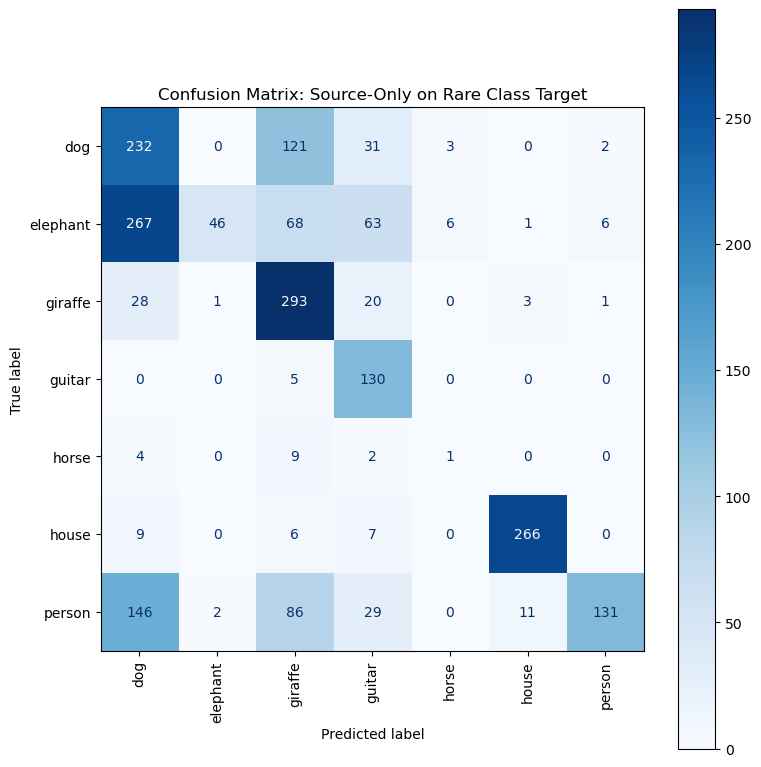

Overall Accuracy for DANN: 65.18%


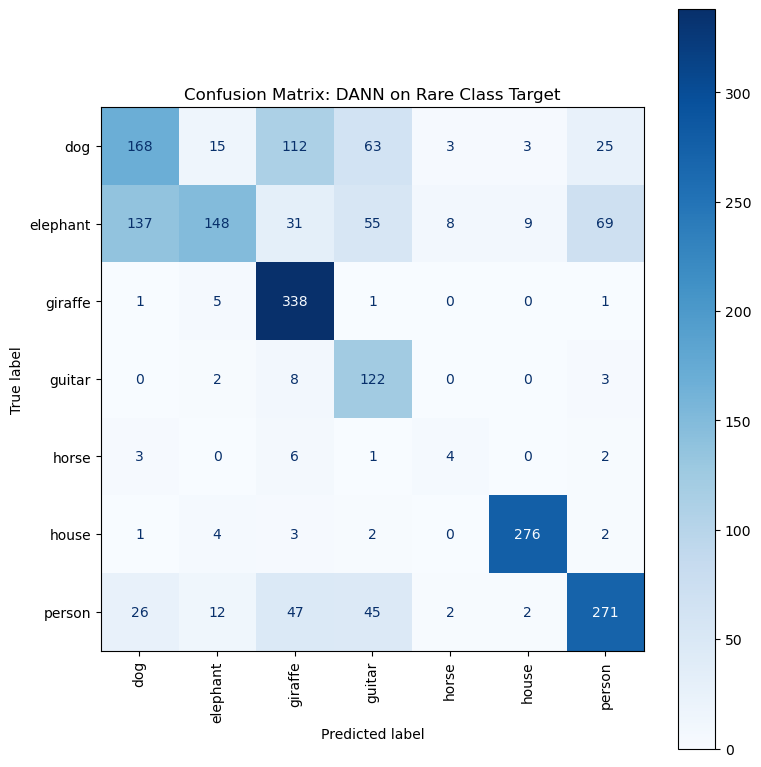

Overall Accuracy for DAN: 60.61%


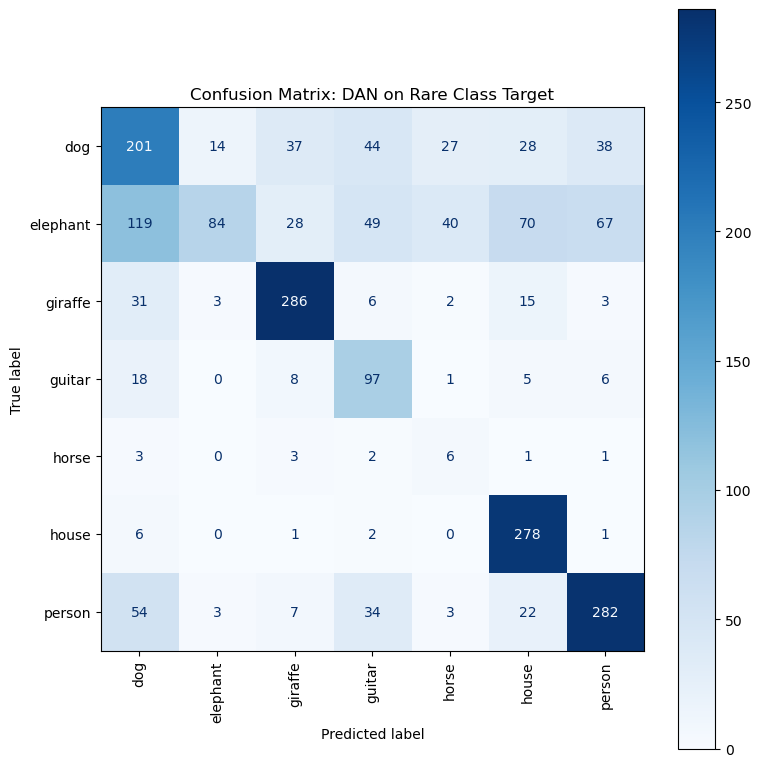

Overall Accuracy for CDAN: 61.89%


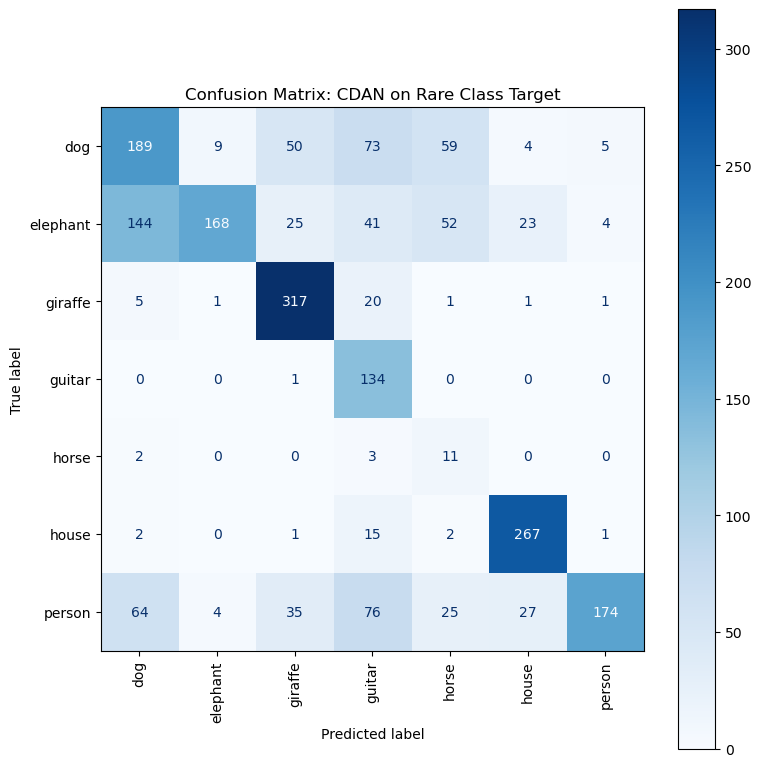

Overall Accuracy for Pseudo-Labeling: 62.67%


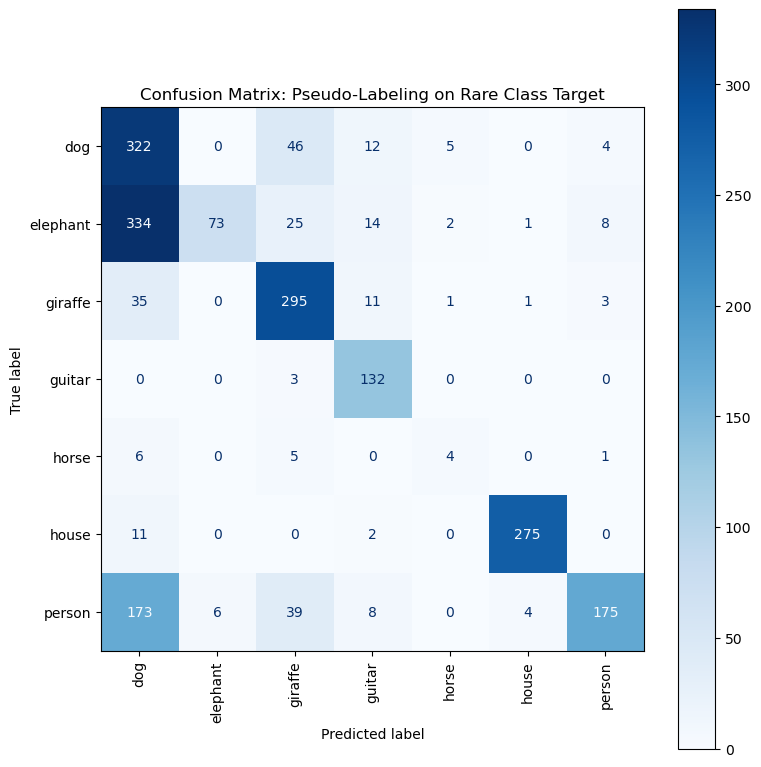

Generating t-SNE plot for Source-Only...


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


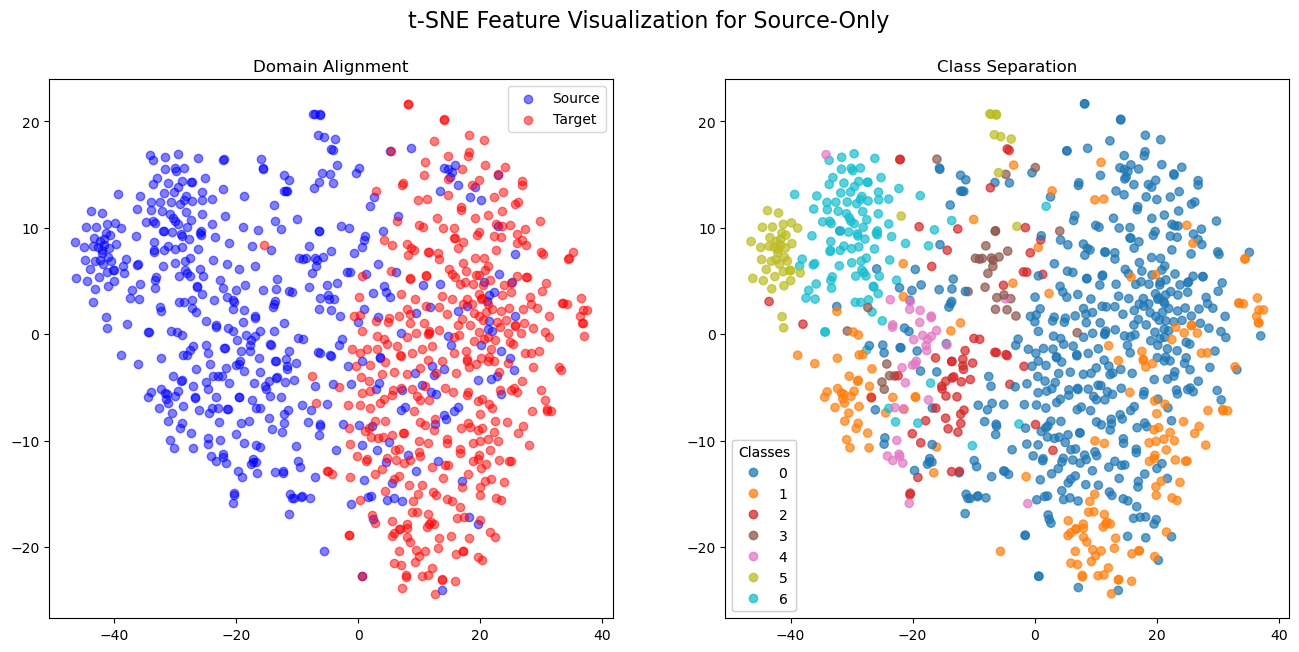

Generating t-SNE plot for DANN...


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


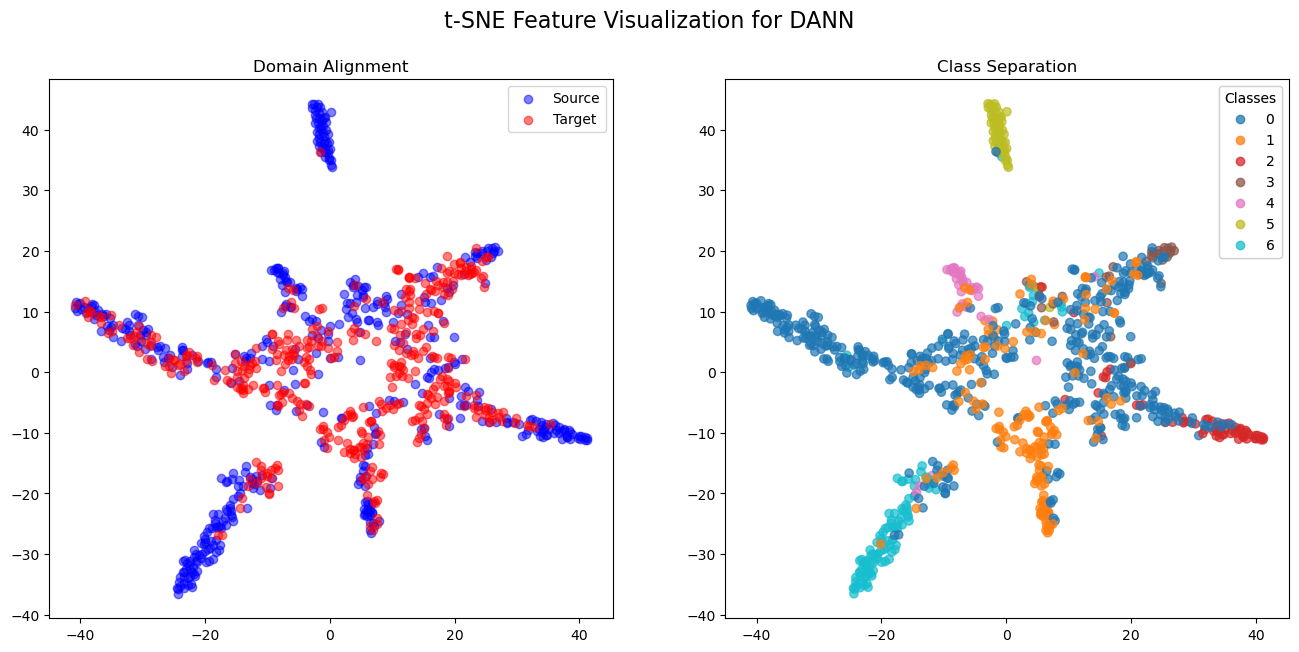

Generating t-SNE plot for DAN...


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


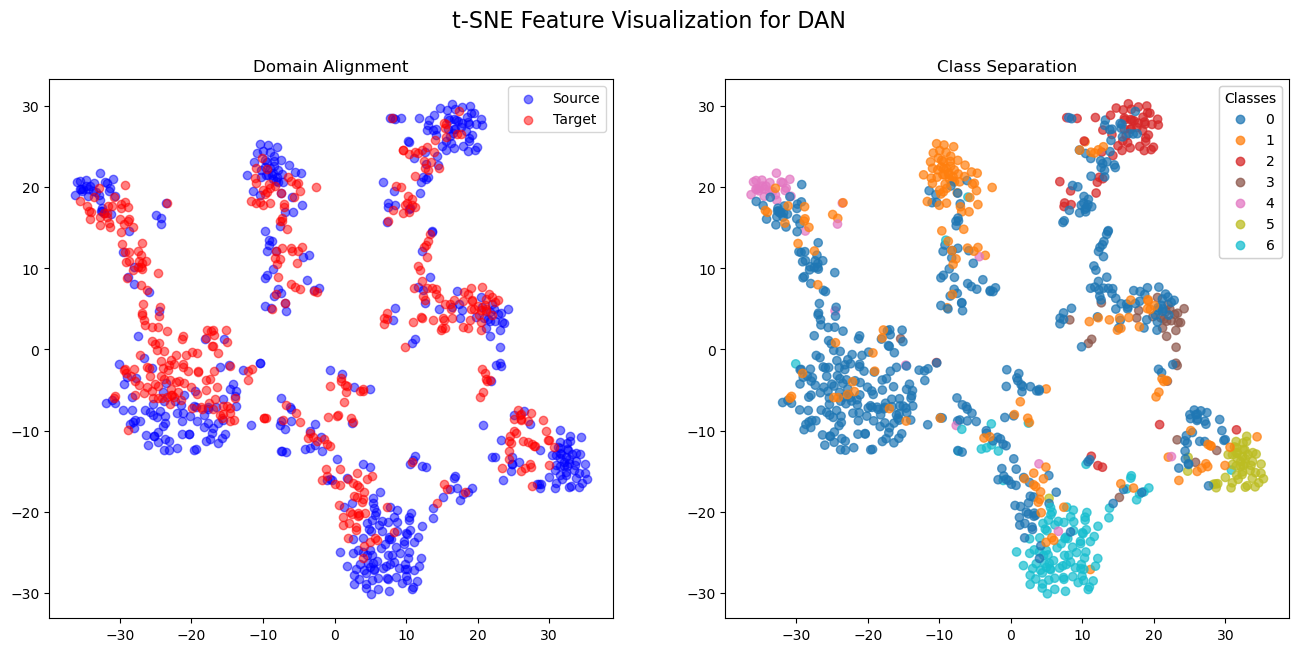

Generating t-SNE plot for CDAN...


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


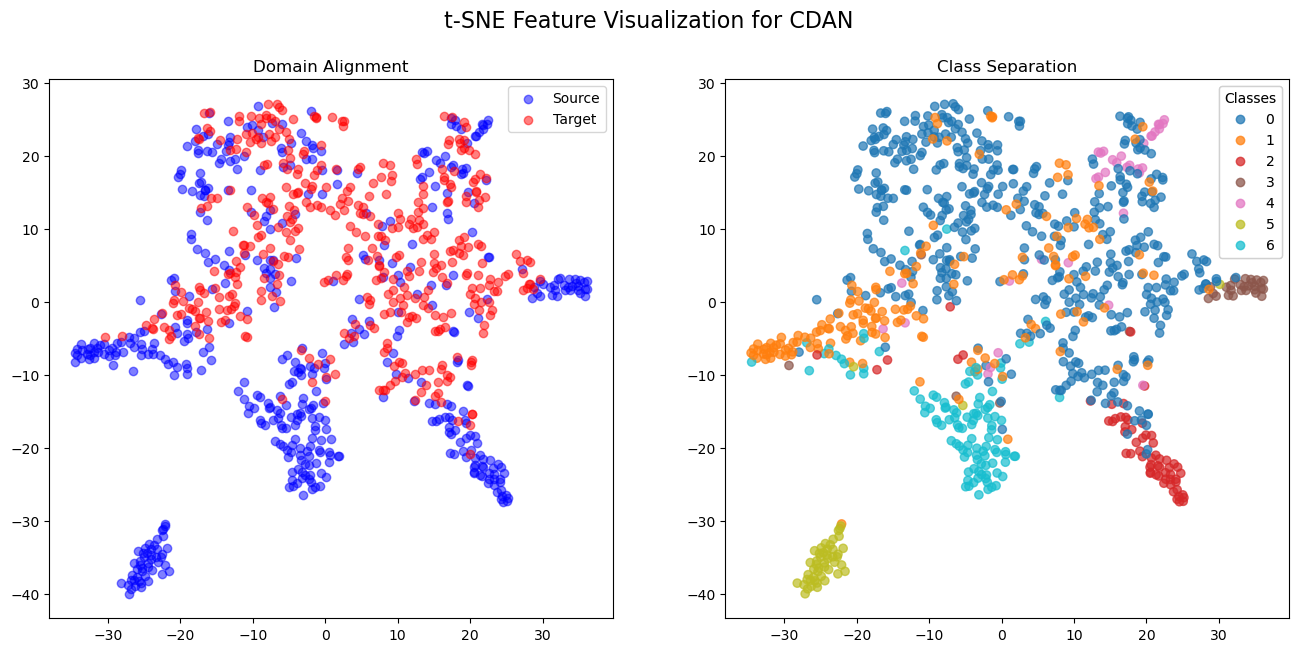

Generating t-SNE plot for Pseudo-Labeling...


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


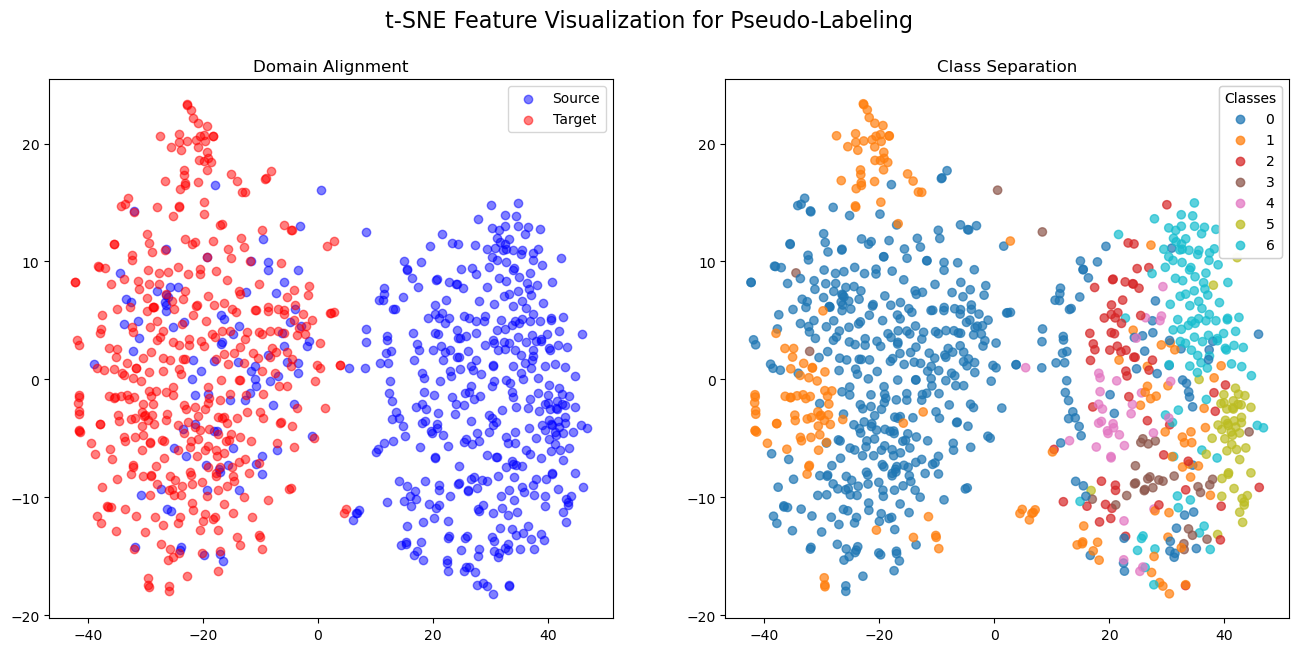

In [ ]:

import torch
from torch.utils.data import Subset
torch.cuda.empty_cache()


class_names = full_source_dataset.classes
print("Classes:", class_names)


CLASS_TO_REMOVE_IDX = 3 
print(f"Removing class: '{class_names[CLASS_TO_REMOVE_IDX]}'")



original_indices = range(len(target_dataset))


indices_to_keep = [i for i in original_indices if target_dataset.targets[i] != CLASS_TO_REMOVE_IDX]


target_dataset_missing_class = Subset(target_dataset, indices_to_keep)


target_loader_missing_class = DataLoader(target_dataset_missing_class, batch_size=BATCH_SIZE, shuffle=False)

print(f"Original target dataset size: {len(target_dataset)}")
print(f"New target dataset size: {len(target_dataset_missing_class)}")


print("\n--- Evaluating on Target Domain with Missing Class ---")


print("\n--- Source-Only Model ---")

evaluate(source_model, target_loader_missing_class, "Target (Missing Class)")


print("\n--- DANN Model ---")
evaluate_dann(dann_model, target_loader_missing_class, "Target (Missing Class)")


print("\n--- DAN Model ---")
evaluate_dan(dan_model, target_loader_missing_class, "Target (Missing Class)")


print("\n--- CDAN Model ---")
evaluate_cdan(cdan_model, target_loader_missing_class, "Target (Missing Class)")


print("\n--- Pseudo-Labeling Model ---")
evaluate(pseudo_label_model, target_loader_missing_class, "Target (Missing Class)")
import random




RARE_CLASS_IDX = 4

PERCENT_TO_KEEP = 0.05 
print(f"Making class '{class_names[RARE_CLASS_IDX]}' rare...")
# ---

original_indices = range(len(target_dataset))
indices_to_keep_rare = []

rare_class_original_indices = [i for i in original_indices if target_dataset.targets[i] == RARE_CLASS_IDX]

num_to_keep = int(len(rare_class_original_indices) * PERCENT_TO_KEEP)
rare_class_sampled_indices = random.sample(rare_class_original_indices, num_to_keep)


indices_of_other_classes = [i for i in original_indices if target_dataset.targets[i] != RARE_CLASS_IDX]
final_indices_rare = indices_of_other_classes + rare_class_sampled_indices


target_dataset_rare_class = Subset(target_dataset, final_indices_rare)
target_loader_rare_class = DataLoader(target_dataset_rare_class, batch_size=BATCH_SIZE, shuffle=False)

print(f"Original target dataset size: {len(target_dataset)}")
print(f"New rare-class target dataset size: {len(target_dataset_rare_class)}")
print(f"Number of samples for rare class '{class_names[RARE_CLASS_IDX]}': {num_to_keep}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot_confusion_matrix(model, model_name, dataloader):
  
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            
        
            if "dann" in model_name.lower() or "cdan" in model_name.lower():
                label_outputs, _ = model(inputs)
          
            elif "dan" in model_name.lower():
                _, label_outputs = model(inputs)
           
            else:
                label_outputs = model(inputs)
           

            _, predicted = torch.max(label_outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    if not all_labels:
        print(f"No samples found for {model_name}. Skipping evaluation.")
        return

    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Overall Accuracy for {model_name}: {accuracy:.2f}%")

    
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    ax.set_title(f'Confusion Matrix: {model_name} on Rare Class Target')
    plt.tight_layout()
    plt.show()


print("\n--- Re-evaluating on Target Domain with Rare Class ---")
evaluate_and_plot_confusion_matrix(source_model, "Source-Only", target_loader_rare_class)
evaluate_and_plot_confusion_matrix(dann_model, "DANN", target_loader_rare_class)
evaluate_and_plot_confusion_matrix(dan_model, "DAN", target_loader_rare_class)
evaluate_and_plot_confusion_matrix(cdan_model, "CDAN", target_loader_rare_class)
evaluate_and_plot_confusion_matrix(pseudo_label_model, "Pseudo-Labeling", target_loader_rare_class)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def plot_tsne(model, model_name, source_loader, target_loader, n_samples=500):
    
    print(f"Generating t-SNE plot for {model_name}...")
    model.eval()
    
  
    source_features, source_labels = [], []
    target_features, target_labels = [], []

    with torch.no_grad():
       
        for inputs, labels in source_loader:
            inputs = inputs.to(DEVICE)
            if "dan" in model_name.lower():
                feats, _ = model(inputs)
            elif "dann" in model_name.lower() or "cdan" in model_name.lower():
              
                feats = model.feature_extractor(inputs)
            else: 
                temp_fc = model.fc
                model.fc = nn.Identity()
                feats = model(inputs)
                model.fc = temp_fc 
                
            source_features.append(feats.cpu().numpy())
            source_labels.append(labels.cpu().numpy())
            if sum(len(f) for f in source_features) > n_samples: break
                
        
        for inputs, labels in target_loader:
            inputs = inputs.to(DEVICE)
            if "dan" in model_name.lower():
                feats, _ = model(inputs)
            elif "dann" in model_name.lower() or "cdan" in model_name.lower():
                feats = model.feature_extractor(inputs)
            else: 
                temp_fc = model.fc
                model.fc = nn.Identity()
                feats = model(inputs)
                model.fc = temp_fc
                
            target_features.append(feats.cpu().numpy())
            target_labels.append(labels.cpu().numpy())
            if sum(len(f) for f in target_features) > n_samples: break

    source_features = np.concatenate(source_features, axis=0)[:n_samples]
    source_labels = np.concatenate(source_labels, axis=0)[:n_samples]
    target_features = np.concatenate(target_features, axis=0)[:n_samples]
    target_labels = np.concatenate(target_labels, axis=0)[:n_samples]

   
    all_features = np.concatenate([source_features, target_features], axis=0)
    
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, n_iter=1000)
    tsne_features = tsne.fit_transform(all_features)
    
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f't-SNE Feature Visualization for {model_name}', fontsize=16)

  
    ax1.set_title("Domain Alignment")
    ax1.scatter(tsne_features[:n_samples, 0], tsne_features[:n_samples, 1], c='b', alpha=0.5, label='Source')
    ax1.scatter(tsne_features[n_samples:, 0], tsne_features[n_samples:, 1], c='r', alpha=0.5, label='Target')
    ax1.legend()

   
    ax2.set_title("Class Separation")
   
    all_labels = np.concatenate([source_labels, target_labels])
    scatter = ax2.scatter(tsne_features[:, 0], tsne_features[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
    legend1 = ax2.legend(*scatter.legend_elements(), title="Classes")
    ax2.add_artist(legend1)

    plt.show()

source_loader_for_tsne = source_test_loader
target_loader_for_tsne = target_loader

plot_tsne(source_model, "Source-Only", source_loader_for_tsne, target_loader_for_tsne)
plot_tsne(dann_model, "DANN", source_loader_for_tsne, target_loader_for_tsne)
plot_tsne(dan_model, "DAN", source_loader_for_tsne, target_loader_for_tsne)
plot_tsne(cdan_model, "CDAN", source_loader_for_tsne, target_loader_for_tsne)
plot_tsne(pseudo_label_model, "Pseudo-Labeling", source_loader_for_tsne, target_loader_for_tsne)




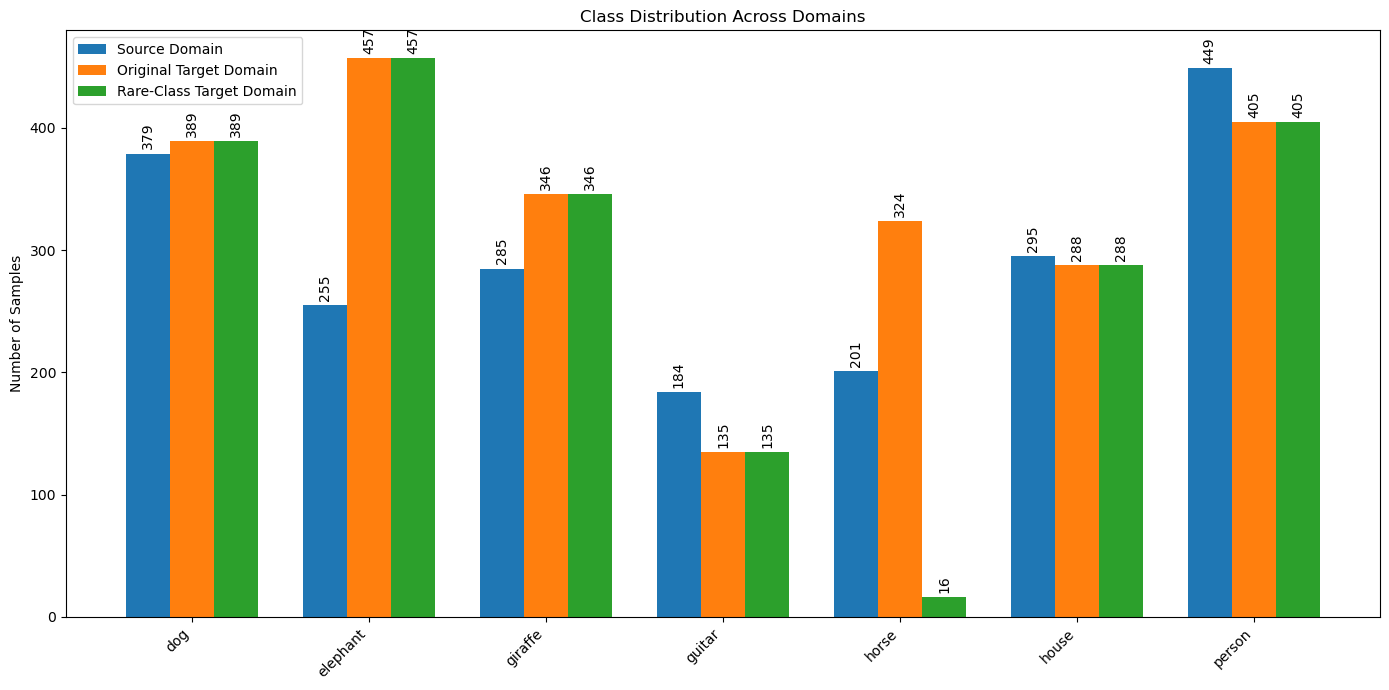

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distributions(source_dataset, target_dataset, rare_class_dataset, class_names):
   
    source_counts = np.bincount(source_dataset.targets, minlength=len(class_names))
    target_counts = np.bincount(target_dataset.targets, minlength=len(class_names))
    
   
    rare_class_original_labels = [target_dataset.targets[i] for i in rare_class_dataset.indices]
    rare_class_counts = np.bincount(rare_class_original_labels, minlength=len(class_names))
    
   
    x = np.arange(len(class_names)) 
    width = 0.25  

    fig, ax = plt.subplots(figsize=(14, 7))
    rects1 = ax.bar(x - width, source_counts, width, label='Source Domain')
    rects2 = ax.bar(x, target_counts, width, label='Original Target Domain')
    rects3 = ax.bar(x + width, rare_class_counts, width, label='Rare-Class Target Domain')

  
    ax.set_ylabel('Number of Samples')
    ax.set_title('Class Distribution Across Domains')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.legend()
    
    ax.bar_label(rects1, padding=3, rotation=90)
    ax.bar_label(rects2, padding=3, rotation=90)
    ax.bar_label(rects3, padding=3, rotation=90)

    fig.tight_layout()
    plt.show()


full_source_data_for_plot = datasets.ImageFolder(os.path.join(DATASET_ROOT, SOURCE_DOMAIN))

plot_class_distributions(full_source_data_for_plot, target_dataset, target_dataset_rare_class, class_names)